# Timeseries Forecasting on JENA Climate Dataset in R

R can be integrated with Keras (using the tensorflow backend) for machine learning tasks such as timeseries forecasting using LSTMs.

In [1]:
install.packages("keras3")


The downloaded binary packages are in
	/var/folders/lr/dnbpm8g94tbb2hqq4ksn6lgr0000gn/T//RtmpffCOHA/downloaded_packages


In [2]:
library("keras3")

## Dataset Normalization, Splits

In [3]:
df <- read.csv("jena_climate_2009_2016.csv", check.names = FALSE)
# Check the actual column names
colnames(df)
head(df)

[1] "0" "1" "2" "3" "4" "5" "6"

,0,1,2,3,4,5,6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9554511,-2.000020,-1.319782,-0.7884790,-1.500927,2.237658,-0.7329972
2,0.9615279,-2.045185,-1.332806,-0.7905606,-1.519521,2.287838,-0.9360023
3,0.9566665,-2.056766,-1.335410,-0.7926422,-1.523239,2.298608,-1.2830756
4,0.9542358,-2.033604,-1.328898,-0.7947239,-1.508364,2.272906,-1.1848473
5,0.9542358,-2.028972,-1.327596,-0.7947239,-1.508364,2.268256,-1.1979444
6,0.9530204,-2.003494,-1.319782,-0.7947239,-1.493489,2.240351,-1.2699785


In [4]:
step <- 6
past <- 720
future <- 72
learning_rate <- 0.001
batch_size <- 256
epochs <- 20

In [5]:
split_fraction <- 0.715
train_split <- floor(split_fraction * nrow(df))

In [6]:
start <- past + future
end <- start + train_split

In [7]:
train_data <- df[1:train_split-1, ]
val_data <- df[train_split:nrow(df), ]

In [9]:
# Select numeric feature columns (skip column 1 which is Date Time)
# Use columns 2-8 (7 numeric feature columns)
# Convert to numeric matrix to ensure all values are numeric
x_train <- data.matrix(train_data[, 1:7])  # data.matrix converts to numeric matrix

# Select rows from start to end, and column 2 (index 1 in Python, but R is 1-indexed)
# Note: Python's iloc[start:end] is exclusive of end, so in R we use (start+1):end
y_train <- as.numeric(df[start:(end-1), 2])  # Ensure y_train is numeric

# Calculate sequence length
sequence_length <- as.integer(past / step)

In [10]:
dataset_train = keras3::timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length = sequence_length,
    sampling_rate = step,
    batch_size = batch_size,
)

In [11]:
# x_end should be number of rows, not columns
x_end <- nrow(val_data) - past - future
label_start <- train_split + past + future

In [13]:
# Select rows 1 to x_end, and numeric feature columns (columns 2-8, skipping Date Time)
x_val <- data.matrix(val_data[1:x_end, 1:7])  # data.matrix converts to numeric matrix

# Select rows from label_start to end, and column 2 (index 1 in Python)
y_val <- as.numeric(df[label_start:nrow(df), 2])  # Ensure y_val is numeric

In [14]:
dataset_val = keras3::timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length = sequence_length,
    sampling_rate = step,
    batch_size = batch_size,
)

In [15]:
# Get the first batch from the dataset
# In R/keras3, we use as_iterator() and iter_next()
iter <- as_iterator(dataset_train)
batch <- iter_next(iter)
inputs <- batch[[1]]
targets <- batch[[2]]

# Print shapes (dimensions in R)
cat("Input shape:", paste(dim(inputs), collapse = " x "), "\n")
cat("Target shape:", paste(dim(targets), collapse = " x "), "\n")

Input shape: 256 x 120 x 7 
Target shape: 256 


## Model Improvements (CPU-Friendly)

The improved model includes:
1. **Stacked LSTM layers** (64 → 32 units): Better feature extraction from sequences
2. **Dropout regularization** (0.2 on LSTM, 0.3 on dense): Prevents overfitting
3. **Additional dense layer** (16 units with ReLU): Better feature learning
4. **Learning rate scheduling**: Automatically reduces LR when validation loss plateaus
5. **MAE metric**: Better monitoring of prediction accuracy

Total parameters: ~25K (still CPU-friendly, ~5x the original but manageable)


## Creating the Model

In [34]:
# Get input shape from the batch (excluding batch dimension)
# dim(inputs) is c(256, 120, 7) = (batch, sequence_length, features)
# For layer_input, we need c(sequence_length, features) = dim(inputs)[2:3]
input_shape <- dim(inputs)[2:3]  # c(120, 7)

# Create improved model with better architecture
# Stacked LSTM with dropout for regularization (CPU-friendly)
inputs_layer <- keras3::layer_input(shape = input_shape)

# First LSTM layer - returns sequences for stacking
lstm1 <- inputs_layer %>% 
    keras3::layer_lstm(units = 32, return_sequences = TRUE, dropout = 0.2, recurrent_dropout = 0.2)

# Second LSTM layer - processes the sequences from first layer
lstm2 <- lstm1 %>% 
    keras3::layer_lstm(units = 32, return_sequences = FALSE, dropout = 0.2, recurrent_dropout = 0.2)

# Dense layers with dropout for better feature learning
dense1 <- lstm2 %>% 
    keras3::layer_dense(units = 16, activation = "relu") %>%
    keras3::layer_dropout(rate = 0.3)

# Output layer
outputs <- dense1 %>% keras3::layer_dense(units = 1)

In [35]:
model <- keras3::keras_model(inputs = inputs_layer, outputs = outputs)
model %>% keras3::compile(
    optimizer = keras3::optimizer_adam(learning_rate = learning_rate),
    loss = "mse",
    metrics = c("mae")  # Mean Absolute Error for better monitoring
)
# Use summary() directly (it's a generic function, not from keras3 namespace)
summary(model)

Model: "functional_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)        │ (None, 120, 7)           │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                     │ (None, 120, 32)          │         5,120 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                     │ (None, 32)               │         8,320 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_3 (Dense)                   │ (None, 16)               │           528 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout_1 (Dropout)               │ (None, 16)               │             0 │
├─────

In [36]:
checkpoint_path <- "model.weights.h5"
early_stopping <- keras3::callback_early_stopping(
    monitor = "val_loss",
    patience = 10,
    min_delta = 0,
    restore_best_weights = TRUE
)

# Learning rate scheduler - reduces LR when validation loss plateaus
lr_scheduler <- keras3::callback_reduce_lr_on_plateau(
    monitor = "val_loss",
    factor = 0.5,  # Reduce LR by half
    patience = 5,  # Wait 5 epochs
    min_lr = 1e-6,  # Minimum learning rate
    verbose = 1
)

In [37]:
model_cbk <- keras3::callback_model_checkpoint(
    filepath = checkpoint_path,
    monitor = "val_loss",
    verbose = 1,
    save_best_only = TRUE,
    save_weights_only = TRUE
)

In [ ]:
history <- model %>% keras3::fit(
    dataset_train,
    validation_data = dataset_val,
    epochs = epochs,
    callbacks = list(early_stopping, model_cbk, lr_scheduler)
)

In [21]:
visualize_history = function(history, title) {
    loss <- history$metrics$loss
    val_loss <- history$metrics$val_loss
    epochs <- 1:length(loss)
    plot(epochs, loss, 'l', col = 'blue', lwd = 2,
         xlab = "Epochs", ylab = "Loss", main = title)
    lines(epochs, val_loss, col = 'red', lwd = 2)
    legend("topright", legend = c("Training", "Validation"),
           col = c("blue", "red"), lwd = 2)
}

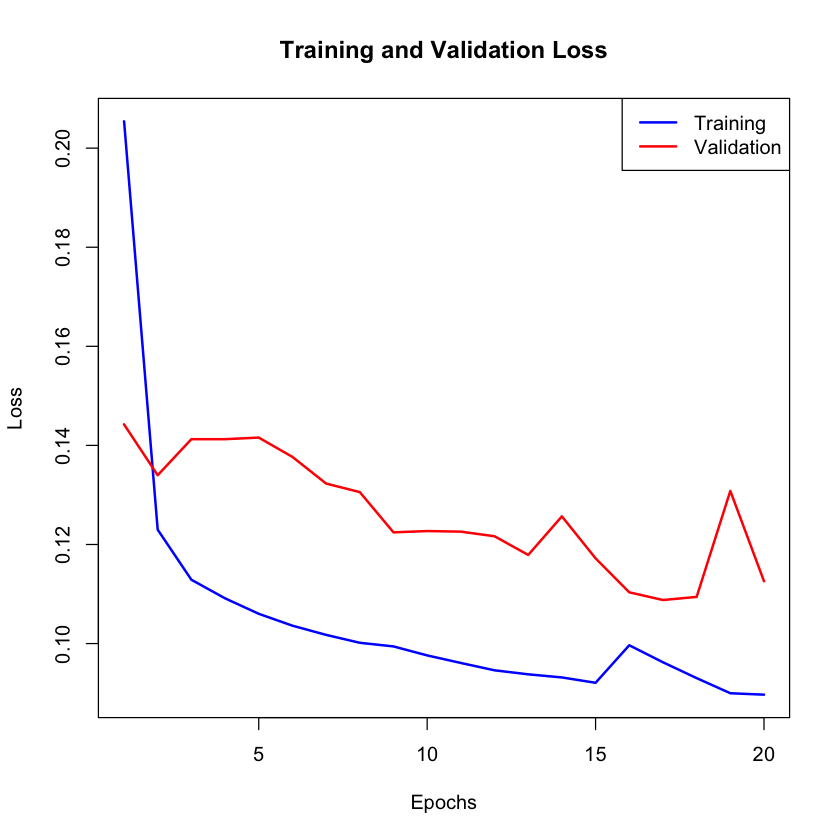

In [22]:
visualize_history(history, "Training and Validation Loss")

## Inference/Prediction

In [30]:
show_plot <- function(plot_data, delta = NULL, title = "") {
    labels <- c("History", "True Future", "Model Prediction")
    marker <- c(1, 4, 1)  # R plot symbols: 1=circle, 4=X, 1=circle
    marker_colors <- c("black", "red", "green")
    
    # Convert all data to R numeric vectors (handle tensors properly)
    plot_data <- lapply(plot_data, function(x) {
        # Check if it's a tensor or Python object
        if (inherits(x, "tensorflow.tensor") || inherits(x, "python.builtin.object")) {
            # Use numpy() method to get numpy array, then convert
            tryCatch({
                if (inherits(x, "tensorflow.tensor")) {
                    # Access numpy array directly
                    np_array <- x$numpy()
                    as.numeric(np_array)
                } else {
                    # For other Python objects, try py_to_r
                    reticulate::py_to_r(x)
                }
            }, error = function(e) {
                # Fallback: try direct conversion
                as.numeric(reticulate::py_to_r(x))
            })
        } else {
            # Already R object, just ensure it's numeric
            as.numeric(x)
        }
    })
    
    # Calculate time steps for history (negative values)
    history_length <- length(plot_data[[1]])
    time_steps <- seq(-history_length, -1)
    
    # Determine future time step
    if (!is.null(delta)) {
        future <- delta
    } else {
        future <- 0
    }
    
    # Create the plot
    plot(NULL, 
         xlim = c(time_steps[1], (future + 5) * 2),
         ylim = range(unlist(plot_data), na.rm = TRUE),
         xlab = "Time-Step",
         ylab = "Value",
         main = title,
         type = "n")
    
    # Plot history (first element)
    lines(time_steps, plot_data[[1]], 
          type = "b", pch = marker[1], col = marker_colors[1], 
          lwd = 2, lty = 1)
    
    # Plot true future and model prediction (if they exist)
    if (length(plot_data) > 1) {
        for (i in 2:length(plot_data)) {
            # Handle scalar values (single predictions)
            if (length(plot_data[[i]]) == 1) {
                points(future, plot_data[[i]], 
                       pch = marker[i], col = marker_colors[i], cex = 1.5)
            } else {
                points(rep(future, length(plot_data[[i]])), plot_data[[i]], 
                       pch = marker[i], col = marker_colors[i], cex = 1.5)
            }
        }
    }
    
    # Add legend
    legend("topright", 
           legend = labels[1:length(plot_data)],
           col = marker_colors[1:length(plot_data)],
           pch = marker[1:length(plot_data)],
           lty = c(1, rep(NA, length(plot_data) - 1)),
           lwd = c(2, rep(NA, length(plot_data) - 1)))
}

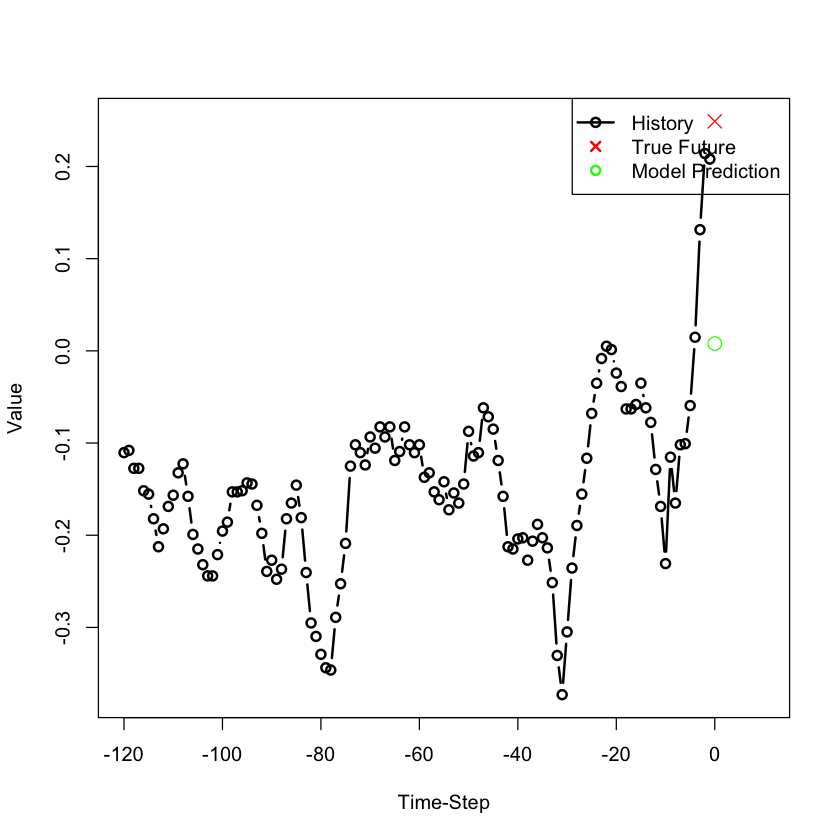

In [31]:
iter <- as_iterator(dataset_val)
batch <- iter_next(iter)
x <- batch[[1]]
y <- batch[[2]]

# Convert tensors to R arrays if needed
convert_tensor <- function(t) {
    if (inherits(t, "tensorflow.tensor") || inherits(t, "python.builtin.object")) {
        tryCatch({
            if (inherits(t, "tensorflow.tensor")) {
                t$numpy()
            } else {
                reticulate::py_to_r(t)
            }
        }, error = function(e) {
            as.numeric(reticulate::py_to_r(t))
        })
    } else {
        t
    }
}

x <- convert_tensor(x)
y <- convert_tensor(y)

# For prediction, we need to keep the batch dimension
# x[1, , ] gives shape (120, 7), but model needs (1, 120, 7)
# Add batch dimension back using array() with dim parameter
x_single <- array(x[1, , ], dim = c(1, dim(x)[2], dim(x)[3]))

# Predict (this will return a tensor, convert to R numeric)
prediction_tensor <- predict(model, x_single)
prediction <- as.numeric(convert_tensor(prediction_tensor)[1, 1])

# x[1, , 1] is the history sequence (first feature of first batch)
history_seq <- as.numeric(x[1, , 1])
true_future <- as.numeric(y[1])

# Show plot: history (sequence), true future value, predicted value
show_plot(list(history_seq, true_future, prediction))